# Как найти стог сена в иголке? Практический проект по построению системы поиска аномалий

In [1]:
!pip install umap-learn

In [2]:
!pip install MulticoreTSNE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Часть 1. EDA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import umap
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

%matplotlib inline

plt.rcParams["figure.figsize"] = (12,8)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
data = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/5/creditcard.csv')

In [6]:
data.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

In [7]:
data.shape

(284807, 31)

In [8]:
data.describe()

Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

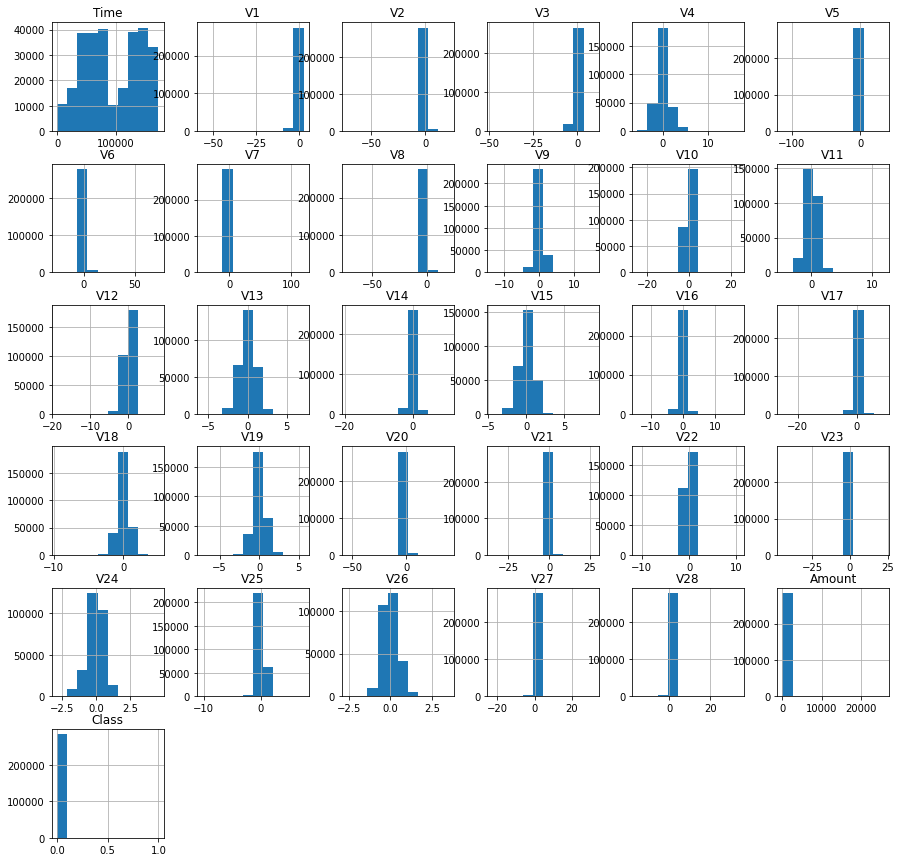

In [11]:
data.hist(figsize=(15,15));

In [12]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

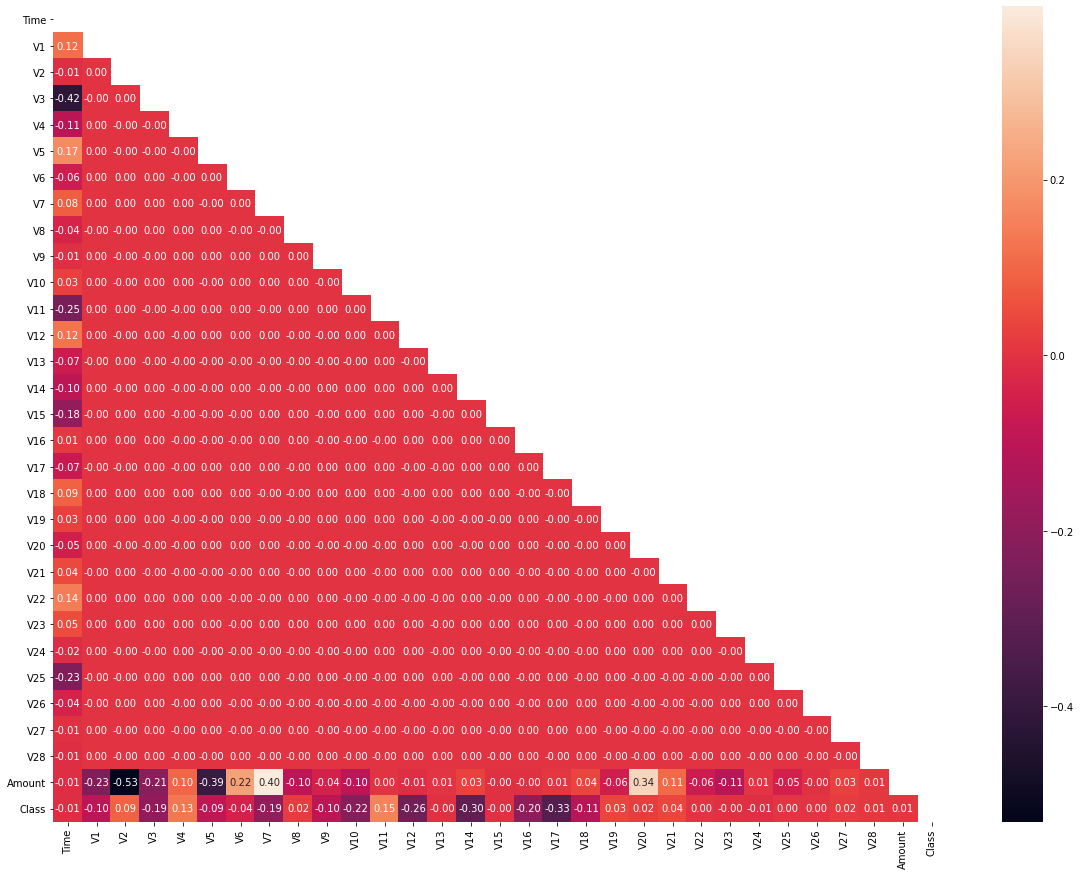

In [13]:
plt.figure(figsize=(20,15))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f');

In [14]:
data.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [15]:
data.Class.value_counts(normalize=True)[1]

0.001727485630620034

0,17 процентов экспертной оценки - сомнительные операции.

In [16]:
data.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

Распределение Time

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


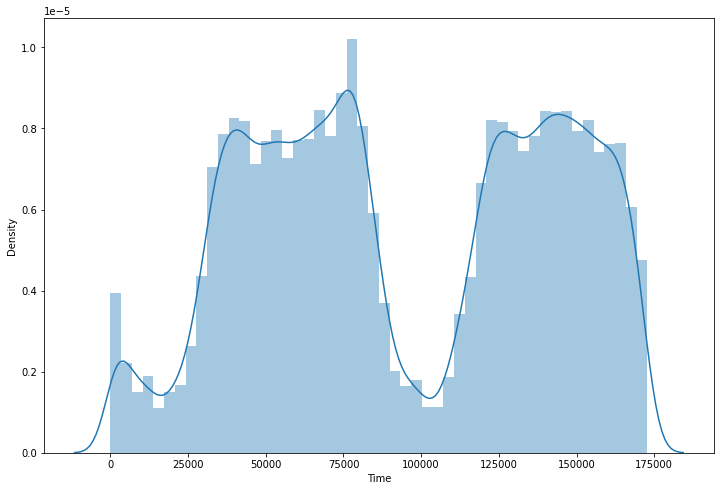

In [17]:
sns.distplot(data.Time, kde = True)

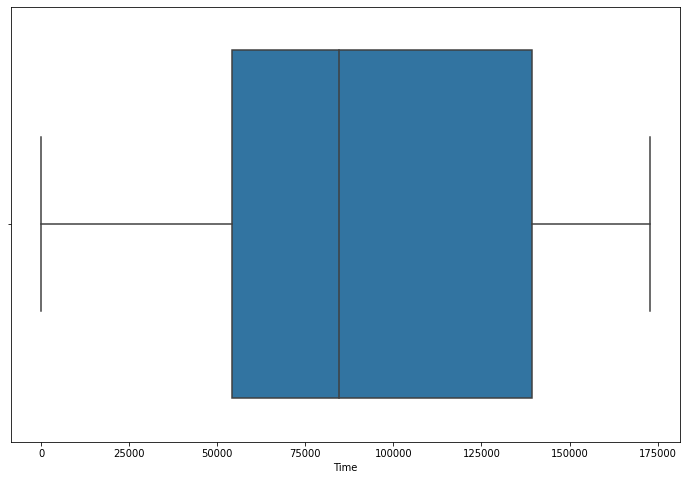

In [18]:
sns.boxplot(x=data["Time"])

Распределение Amount

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


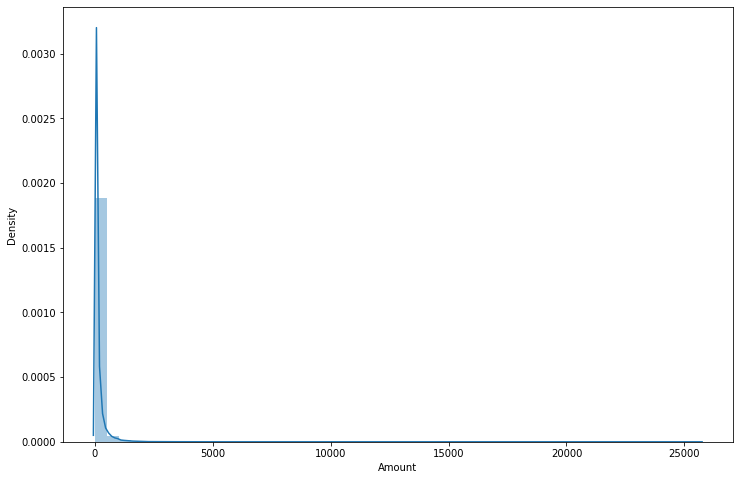

In [19]:
sns.distplot(data.Amount, kde = True)

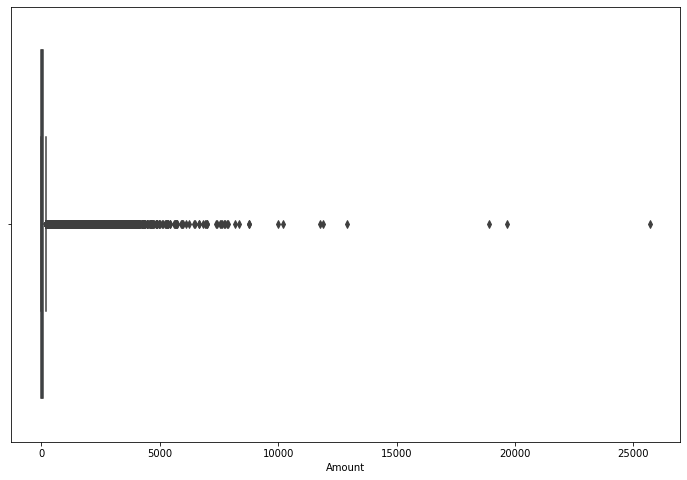

In [20]:
sns.boxplot(x=data["Amount"])

переменная Amount имеет много выбросов, прологарифмируем переменную

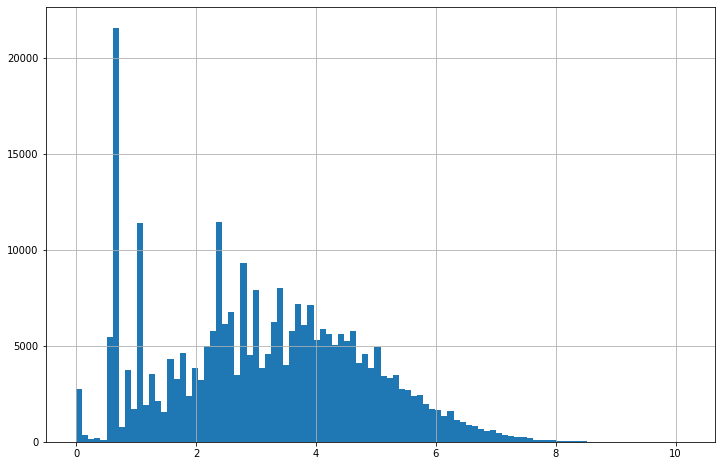

In [21]:
np.log(data['Amount']+1).hist(bins = 100)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


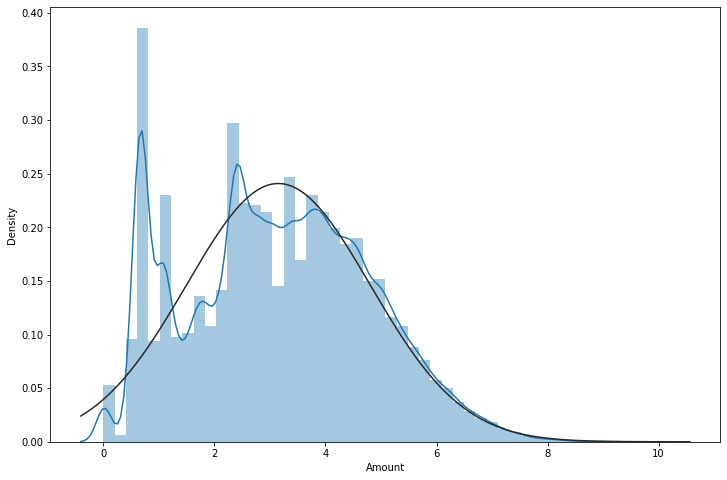

In [22]:
sns.distplot(np.log(data['Amount']+1), fit=norm)

In [23]:
data['Amount_log'] = np.log(data['Amount']+1)

In [24]:
data.head()

Time        V1        V2        V3  ...       V28  Amount  Class  Amount_log
0   0.0 -1.359807 -0.072781  2.536347  ... -0.021053  149.62      0    5.014760
1   0.0  1.191857  0.266151  0.166480  ...  0.014724    2.69      0    1.305626
2   1.0 -1.358354 -1.340163  1.773209  ... -0.059752  378.66      0    5.939276
3   1.0 -0.966272 -0.185226  1.792993  ...  0.061458  123.50      0    4.824306
4   2.0 -1.158233  0.877737  1.548718  ...  0.215153   69.99      0    4.262539

[5 rows x 32 columns]

In [25]:
data.columns[1:29]

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

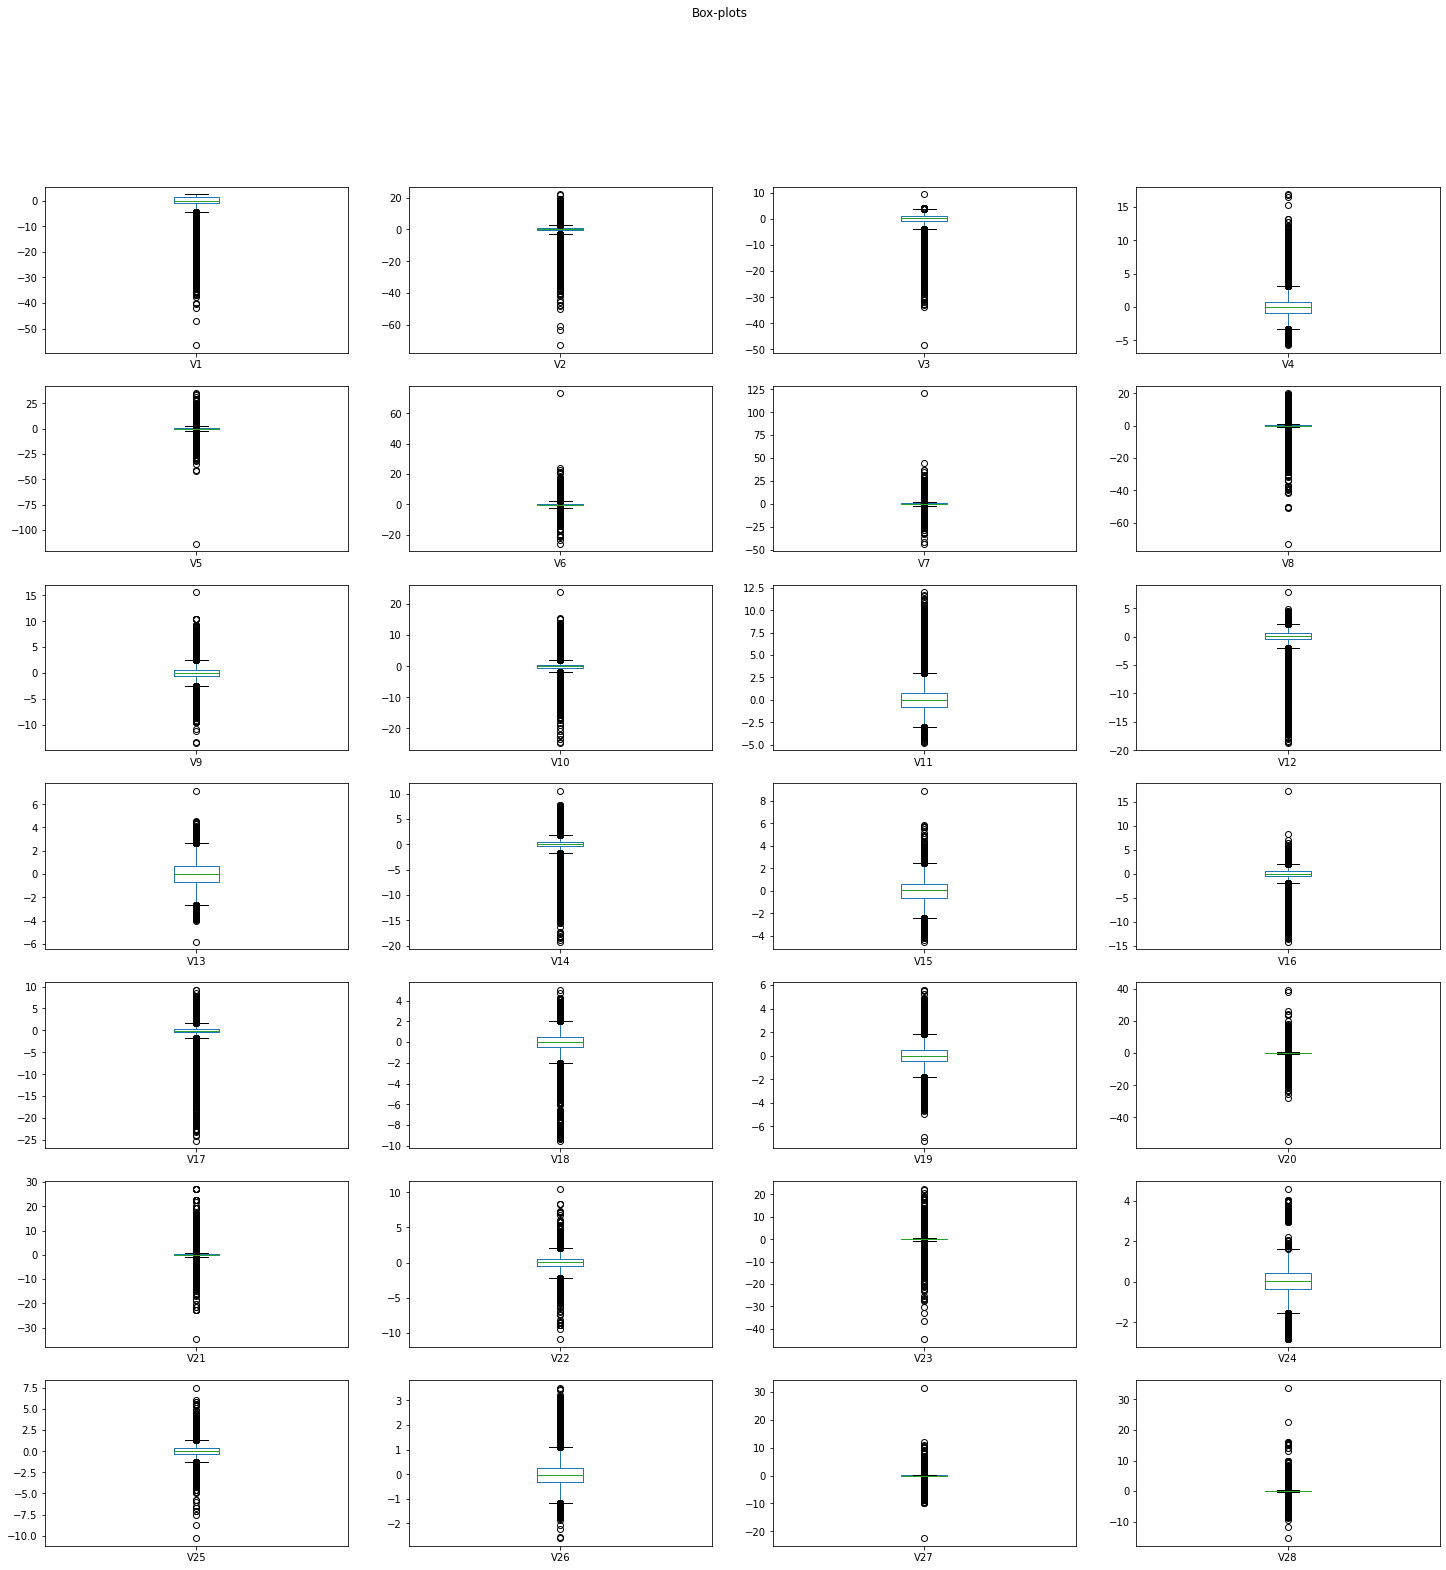

In [26]:
fig, axes = plt.subplots(7, 4, figsize=(25, 25))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(data.columns[1:29]):
    data[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 3:
        row+=1
        col=0

# Часть 2. Моделирование

### Шкалирование

In [27]:
scaler = StandardScaler()
data[['Time_sts', 'Amount_log_sts']] = scaler.fit_transform(data[['Time', 'Amount_log']])

In [28]:
data.head()

Time        V1        V2  ...  Amount_log  Time_sts  Amount_log_sts
0   0.0 -1.359807 -0.072781  ...    5.014760 -1.996583        1.124303
1   0.0  1.191857  0.266151  ...    1.305626 -1.996583       -1.114639
2   1.0 -1.358354 -1.340163  ...    5.939276 -1.996562        1.682368
3   1.0 -0.966272 -0.185226  ...    4.824306 -1.996562        1.009339
4   2.0 -1.158233  0.877737  ...    4.262539 -1.996541        0.670241

[5 rows x 34 columns]

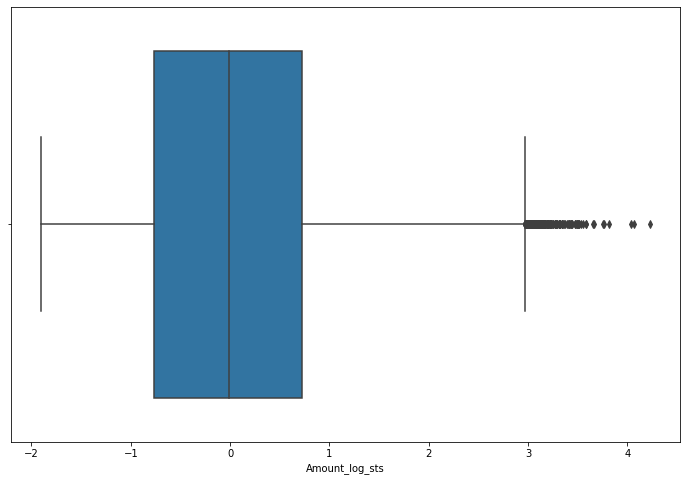

In [29]:
sns.boxplot(x=data["Amount_log_sts"])

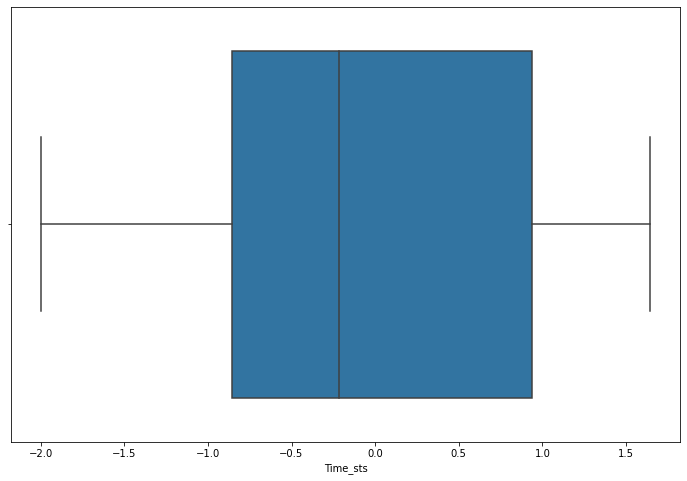

In [30]:
sns.boxplot(x=data["Time_sts"])

In [31]:
data.head()

Time        V1        V2  ...  Amount_log  Time_sts  Amount_log_sts
0   0.0 -1.359807 -0.072781  ...    5.014760 -1.996583        1.124303
1   0.0  1.191857  0.266151  ...    1.305626 -1.996583       -1.114639
2   1.0 -1.358354 -1.340163  ...    5.939276 -1.996562        1.682368
3   1.0 -0.966272 -0.185226  ...    4.824306 -1.996562        1.009339
4   2.0 -1.158233  0.877737  ...    4.262539 -1.996541        0.670241

[5 rows x 34 columns]

### функции для выводов результата и анализа

функция confusion matrix

In [32]:
# Create a confusion matrix
def plot_confusion_matrix(cm, classes = ['No Fraud', 'Fraud'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

функция оценки каества модели

In [33]:
def quality(prediction_y,true_y):
  stats = [
  accuracy_score(prediction_y, true_y),
  precision_score(prediction_y, true_y),
  recall_score(prediction_y, true_y),
  f1_score(prediction_y, true_y)
      ]
  return stats

measured_metrics = pd.DataFrame({"error_type":["Accuracy", "Precision", "recall", "F1-score"]})
measured_metrics.set_index("error_type")

Empty DataFrame
Columns: []
Index: [Accuracy, Precision, recall, F1-score]

аномалии из экспертной оценки

In [34]:
anomaly = data.Class.value_counts(normalize=True)[1]*100
no_anomaly = data.Class.value_counts(normalize=True)[0]*100
print("Аномалии:  {:.3f}\nНе аномалии: {:.3f}".format(
        anomaly, no_anomaly))

Аномалии:  0.173
Не аномалии: 99.827


функция distant_base

In [35]:
def distant_base (X, metric = 'euclidean', percen = no_anomaly):
  centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
  distances_train = cdist(centroid, X, metric=metric).reshape(-1)
  threshold = np.percentile(distances_train, percen)
  distances = cdist(centroid, X, metric=metric).reshape(-1)
  return (distances > threshold).astype(int)

актуальная матрица

In [36]:
actual_cm = confusion_matrix(data.Class.values, data.Class.values)

общая функция отрисовки матрицы и вывода метрик

In [37]:
def main_f(name_model, predict): 
  cm = confusion_matrix(data.Class.values, predict)
  fig = plt.figure(figsize=(16,8))
  fig.add_subplot(221)
  plot_confusion_matrix(cm, title= name_model + "\n Confusion Matrix", cmap=plt.cm.Reds)
  fig.add_subplot(222)
  plot_confusion_matrix(actual_cm, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)
  measured_metrics[name_model] = quality(predict,data.Class.values)
  #print(measured_metrics)

### Distance-based Кластеризация

Проверим качество модели, выкинув признак Time

In [38]:
X_notime = data.iloc[:,1:29].assign(Amount_log_sts = data.Amount_log_sts)

In [39]:
X_notime

V1         V2        V3  ...       V27       V28  Amount_log_sts
0       -1.359807  -0.072781  2.536347  ...  0.133558 -0.021053        1.124303
1        1.191857   0.266151  0.166480  ... -0.008983  0.014724       -1.114639
2       -1.358354  -1.340163  1.773209  ... -0.055353 -0.059752        1.682368
3       -0.966272  -0.185226  1.792993  ...  0.062723  0.061458        1.009339
4       -1.158233   0.877737  1.548718  ...  0.219422  0.215153        0.670241
...           ...        ...       ...  ...       ...       ...             ...
284802 -11.881118  10.071785 -9.834783  ...  0.943651  0.823731       -1.558093
284803  -0.732789  -0.055080  2.035030  ...  0.068472 -0.053527        0.059034
284804   1.919565  -0.301254 -3.249640  ...  0.004455 -0.026561        0.652027
284805  -0.240440   0.530483  0.702510  ...  0.108821  0.104533       -0.455313
284806  -0.533413  -0.189733  0.703337  ... -0.002415  0.013649        1.347486

[284807 rows x 29 columns]

In [40]:
euclid_notime_outliers = distant_base(X_notime)

error_type  Euclid_notime
0   Accuracy       0.997339
1  Precision       0.229675
2     recall       0.229675
3   F1-score       0.229675

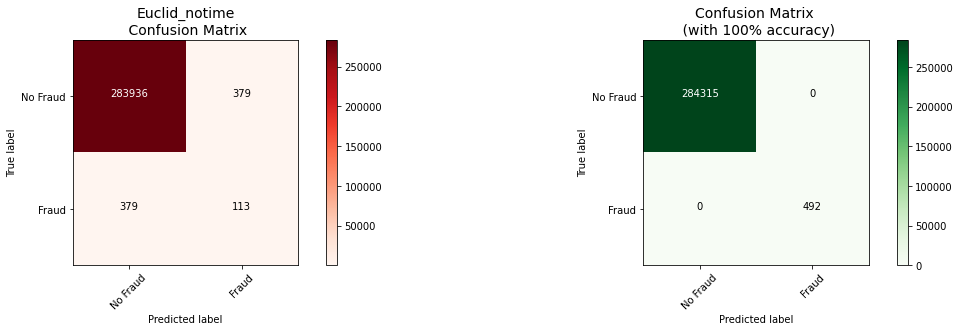

In [41]:
main_f('Euclid_notime', euclid_notime_outliers)
measured_metrics

проверим качество с временной меткой

In [42]:
X_time = pd.concat([data.iloc[:,1:29],data.iloc[:,32:34]], axis=1)

In [43]:
X_time

V1         V2        V3  ...       V28  Time_sts  Amount_log_sts
0       -1.359807  -0.072781  2.536347  ... -0.021053 -1.996583        1.124303
1        1.191857   0.266151  0.166480  ...  0.014724 -1.996583       -1.114639
2       -1.358354  -1.340163  1.773209  ... -0.059752 -1.996562        1.682368
3       -0.966272  -0.185226  1.792993  ...  0.061458 -1.996562        1.009339
4       -1.158233   0.877737  1.548718  ...  0.215153 -1.996541        0.670241
...           ...        ...       ...  ...       ...       ...             ...
284802 -11.881118  10.071785 -9.834783  ...  0.823731  1.641931       -1.558093
284803  -0.732789  -0.055080  2.035030  ... -0.053527  1.641952        0.059034
284804   1.919565  -0.301254 -3.249640  ... -0.026561  1.641974        0.652027
284805  -0.240440   0.530483  0.702510  ...  0.104533  1.641974       -0.455313
284806  -0.533413  -0.189733  0.703337  ...  0.013649  1.642058        1.347486

[284807 rows x 30 columns]

error_type  Euclid_notime  Euclid_time
0   Accuracy       0.997339     0.997339
1  Precision       0.229675     0.229675
2     recall       0.229675     0.229675
3   F1-score       0.229675     0.229675

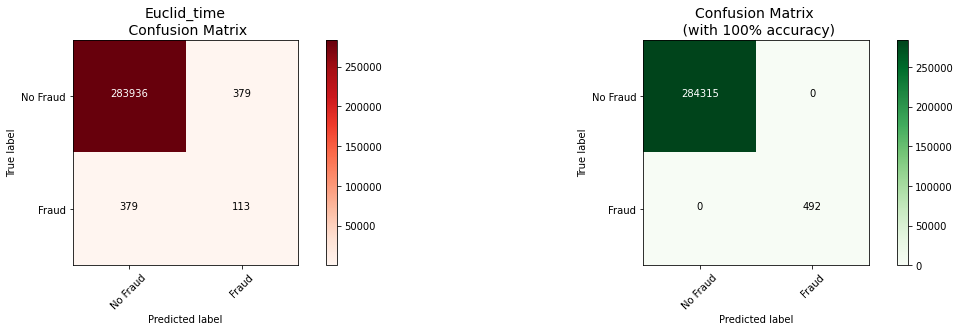

In [44]:
euclid_time_outliers = distant_base(X_time)
main_f('Euclid_time', euclid_time_outliers)
measured_metrics

Разницы нет, выкидываем time или нет, будем в дальнейшем работать без этой фичи.

In [45]:
X = X_notime.copy()

error_type  Euclid_notime  Euclid_time  Cityblock
0   Accuracy       0.997339     0.997339   0.997511
1  Precision       0.229675     0.229675   0.278455
2     recall       0.229675     0.229675   0.279022
3   F1-score       0.229675     0.229675   0.278739

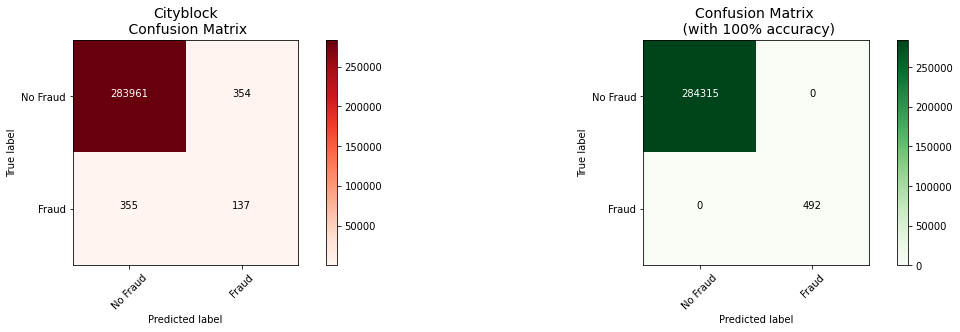

In [46]:
cityblock_outliers = distant_base(X, metric = 'cityblock')
main_f('Cityblock', cityblock_outliers)
measured_metrics

### Снижаем размерность. Воспользуемся t-SNE и UMAP

t-SNE

In [47]:
#tsne = TSNE(perplexity=50, n_jobs=-1, random_state=2021)
#tsne_transformed = tsne.fit_transform(X)
#pd.DataFrame(tsne_transformed).to_csv('/content/drive/MyDrive/STUDY/otus/HW/5/tsne.csv', index = False)
tsne_transformed = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/5/tsne.csv')

UMAP

In [48]:
#reducer = umap.UMAP(random_state=2021)
#X_UMAP = reducer.fit_transform(X)
#pd.DataFrame(X_UMAP).to_csv('/content/drive/MyDrive/STUDY/otus/HW/5/UMAP.csv', index = False)
X_UMAP = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/5/UMAP.csv')

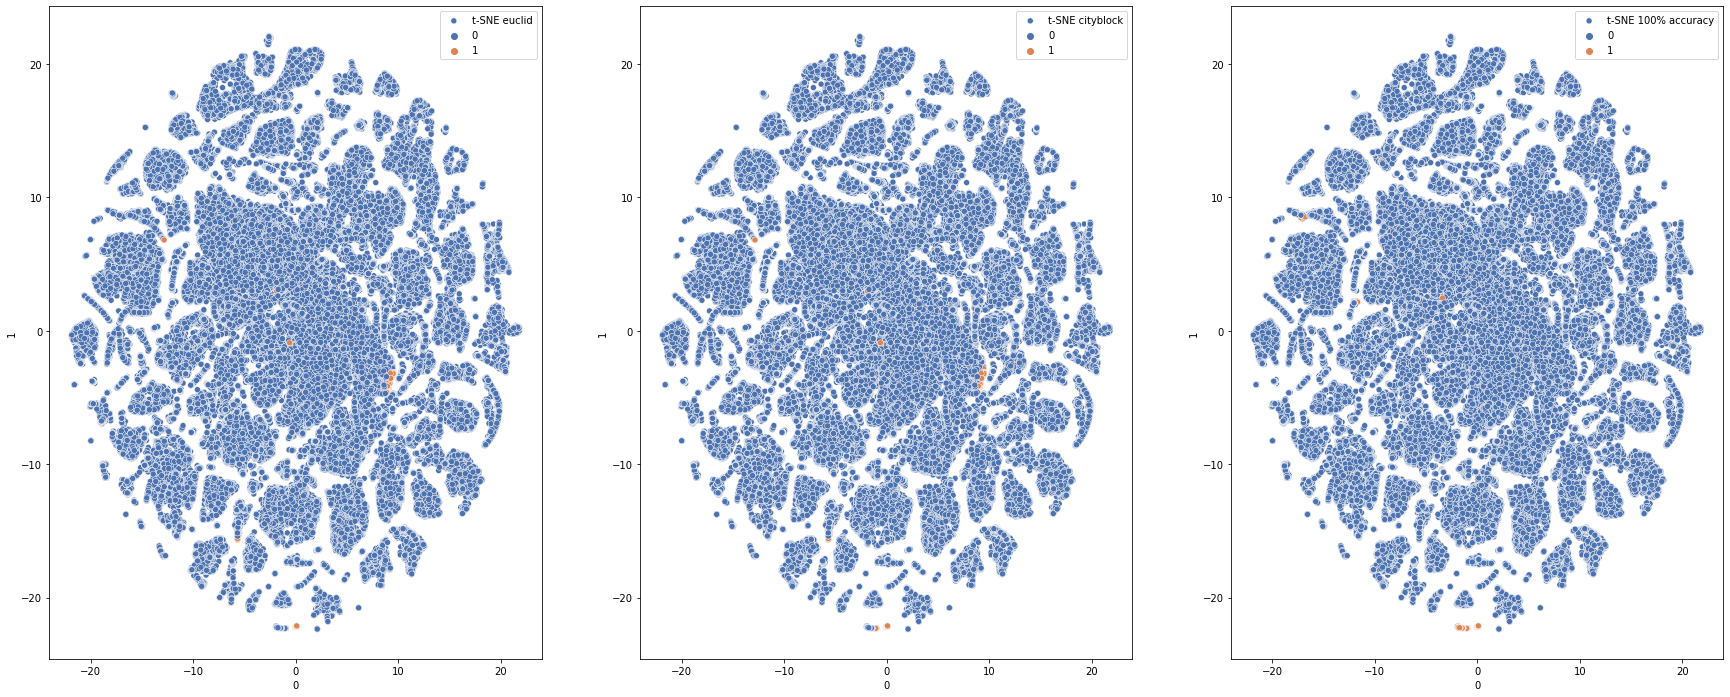

In [49]:
f, axs = plt.subplots(1,3,figsize=(30,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=tsne_transformed['0'], y=tsne_transformed['1'], hue=euclid_notime_outliers, palette= 'deep',legend='full',label = 't-SNE euclid').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=tsne_transformed['0'], y=tsne_transformed['1'], hue=cityblock_outliers,palette= 'deep',legend='full',label = 't-SNE cityblock').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=tsne_transformed['0'], y=tsne_transformed['1'], hue=data.Class.values,palette= 'deep',legend='full',label = 't-SNE 100% accuracy').legend()

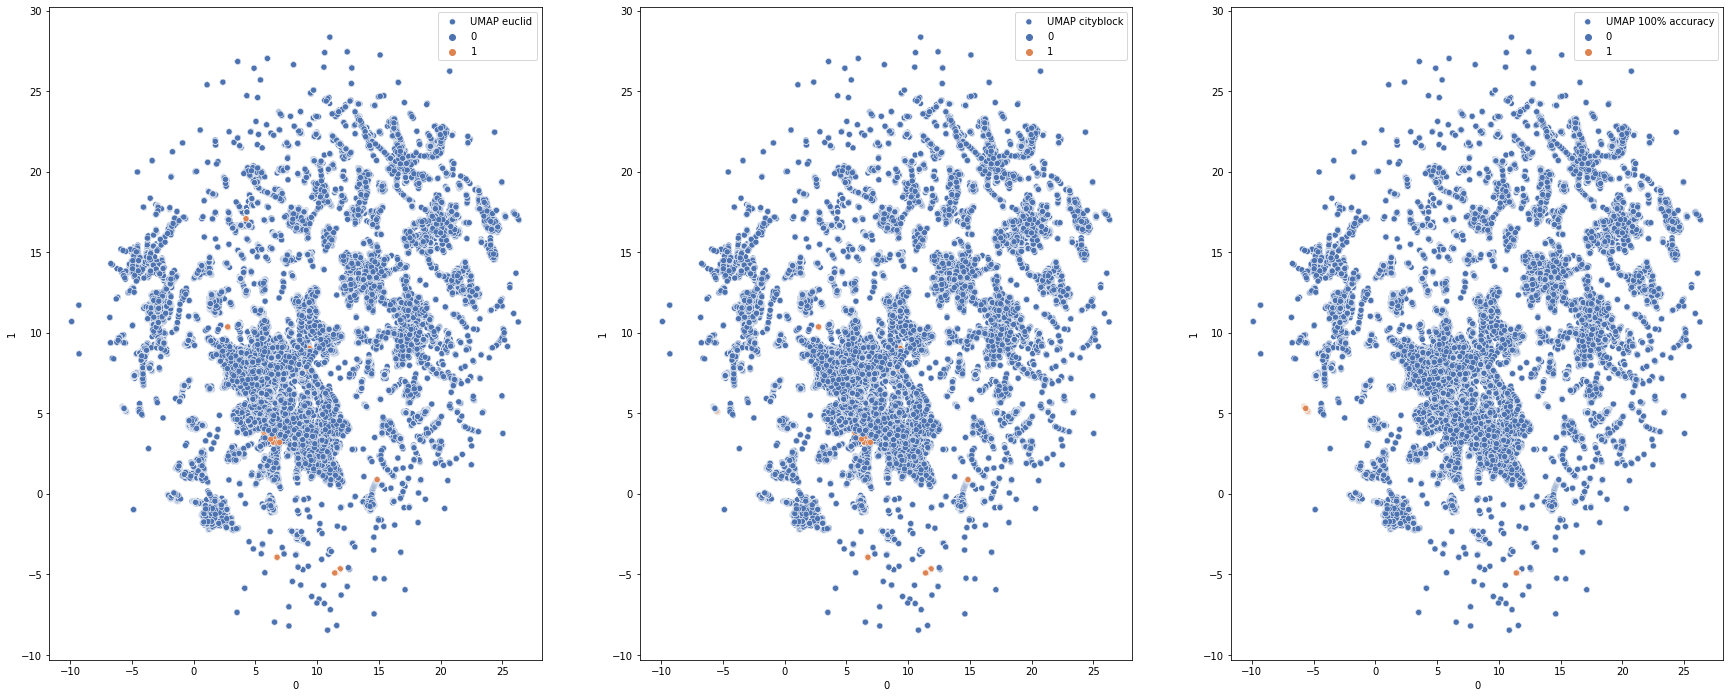

In [50]:
f, axs = plt.subplots(1,3,figsize=(30,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_UMAP['0'], y=X_UMAP['1'], hue=euclid_notime_outliers,palette= 'deep',legend='full',label = 'UMAP euclid').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_UMAP['0'], y=X_UMAP['1'], hue=cityblock_outliers,palette= 'deep',legend='full',label = 'UMAP cityblock').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_UMAP['0'], y=X_UMAP['1'], hue=data.Class.values,palette= 'deep',legend='full',label = 'UMAP 100% accuracy').legend()

### DBSCAN (посчитаем на 10% стратифицированной выборке, иначе считает очень долго)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, data.Class, test_size=0.1, random_state = 2021, stratify = data.Class)
del X_train
del y_train

In [52]:
# outlier_percentage = 1.
# num_clusters = []
# anomaly_percentage = []
# eps_history = []

# берем маленький эпсилон и начинаем увеличивать, но не сильно маленький, чтобы модель отработала быстро.
# eps = 10.0
# eps_history = [eps]
# while outlier_percentage>anomaly/100:    
#     model = DBSCAN(eps=eps).fit(X_test)
#     labels = model.labels_
#     num_clusters.append(len(np.unique(labels))-1)
#     labels = np.array([1 if label == -1 else 0 for label in labels])
#     # считаем текущий процент "шума"
#     outlier_percentage = sum(labels==1) / len(labels)    
#     print(outlier_percentage, eps)
#     eps += 0.05
#     eps_history.append(eps)
#     anomaly_percentage.append(outlier_percentage)

#joblib.dump(model, '/content/drive/MyDrive/STUDY/otus/HW/5/dbscan.pkl')  
model = joblib.load('/content/drive/MyDrive/STUDY/otus/HW/5/dbscan.pkl')  
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

error_type  Euclid_notime  Euclid_time  Cityblock    DBSCAN
0   Accuracy       0.997339     0.997339   0.997511  0.997156
1  Precision       0.229675     0.229675   0.278455  0.142857
2     recall       0.229675     0.229675   0.279022  0.152174
3   F1-score       0.229675     0.229675   0.278739  0.147368

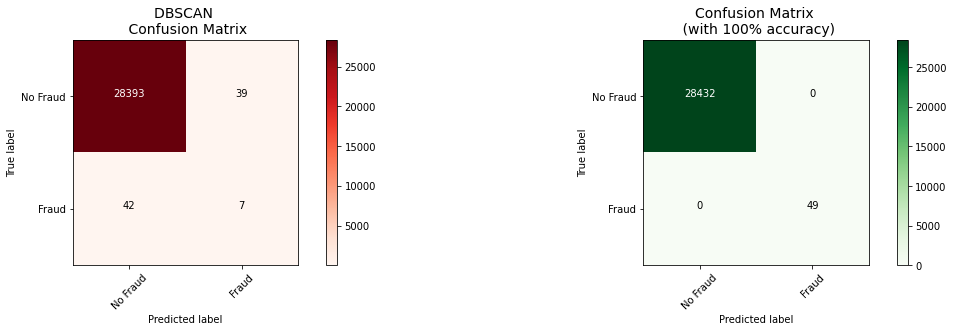

In [53]:
cm = confusion_matrix(y_test, density_outlier)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(221)
plot_confusion_matrix(cm, title="DBSCAN \n Confusion Matrix", cmap=plt.cm.Reds)
fig.add_subplot(222)
plot_confusion_matrix(confusion_matrix(y_test, y_test), title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)
measured_metrics['DBSCAN'] = quality(density_outlier,y_test)
measured_metrics

### One Class SVM

error_type  Euclid_notime  Euclid_time  Cityblock    DBSCAN       SVM
0   Accuracy       0.997339     0.997339   0.997511  0.997156  0.994315
1  Precision       0.229675     0.229675   0.278455  0.142857  0.203252
2     recall       0.229675     0.229675   0.279022  0.152174  0.075358
3   F1-score       0.229675     0.229675   0.278739  0.147368  0.109951

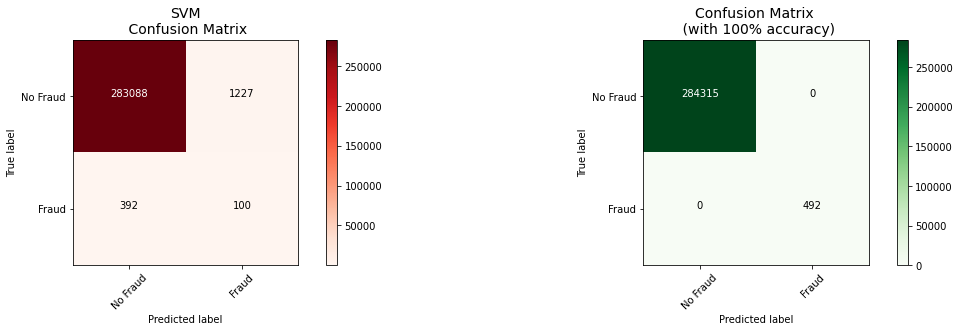

In [54]:
#one_class_svm = OneClassSVM(nu=anomaly/100, gamma='auto')
#one_class_svm.fit(X)
#joblib.dump(one_class_svm, '/content/drive/MyDrive/STUDY/otus/HW/5/one_class_svm.pkl')
one_class_svm = joblib.load('/content/drive/MyDrive/STUDY/otus/HW/5/one_class_svm.pkl')
svm_outliers = one_class_svm.predict(X)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])
main_f('SVM', svm_outliers)
measured_metrics

# Isolation Forest

In [55]:
isolation_forest = IsolationForest(n_estimators=100, contamination=anomaly/100, 
                                   max_features=7, bootstrap=True, behaviour="new", random_state = 2021, )
isolation_forest.fit(X)

isolation_outliers = isolation_forest.predict(X)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


error_type  Euclid_notime  Euclid_time  ...    DBSCAN       SVM  Isol_Forest
0   Accuracy       0.997339     0.997339  ...  0.997156  0.994315     0.997732
1  Precision       0.229675     0.229675  ...  0.142857  0.203252     0.343496
2     recall       0.229675     0.229675  ...  0.152174  0.075358     0.343496
3   F1-score       0.229675     0.229675  ...  0.147368  0.109951     0.343496

[4 rows x 7 columns]

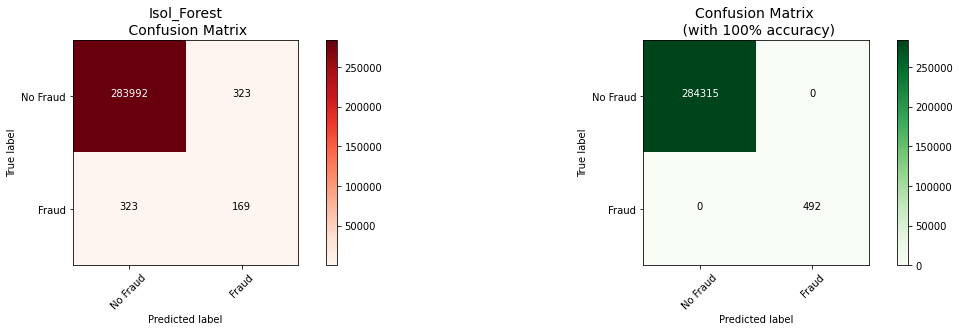

In [56]:
main_f('Isol_Forest', isolation_outliers)
measured_metrics

Визуализируем наши модели с помощью t-SNE и UMAP (SVM, IsolationForest и 100% accutacy)

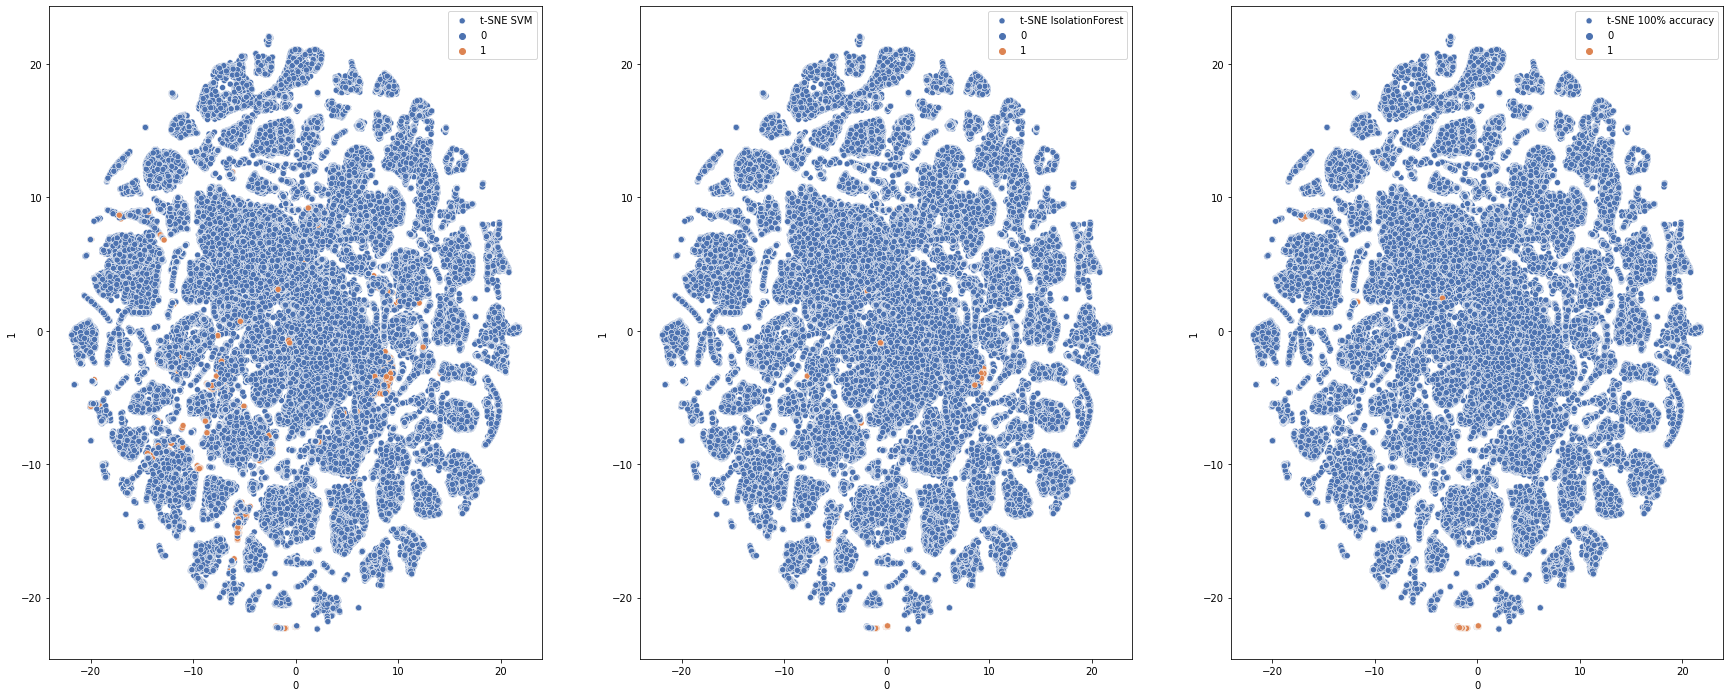

In [57]:
f, axs = plt.subplots(1,3,figsize=(30,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=tsne_transformed['0'], y=tsne_transformed['1'], hue=svm_outliers, palette= 'deep',legend='full',label = 't-SNE SVM').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=tsne_transformed['0'], y=tsne_transformed['1'], hue=isolation_outliers,palette= 'deep',legend='full',label = 't-SNE IsolationForest').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=tsne_transformed['0'], y=tsne_transformed['1'], hue=data.Class.values,palette= 'deep',legend='full',label = 't-SNE 100% accuracy').legend()

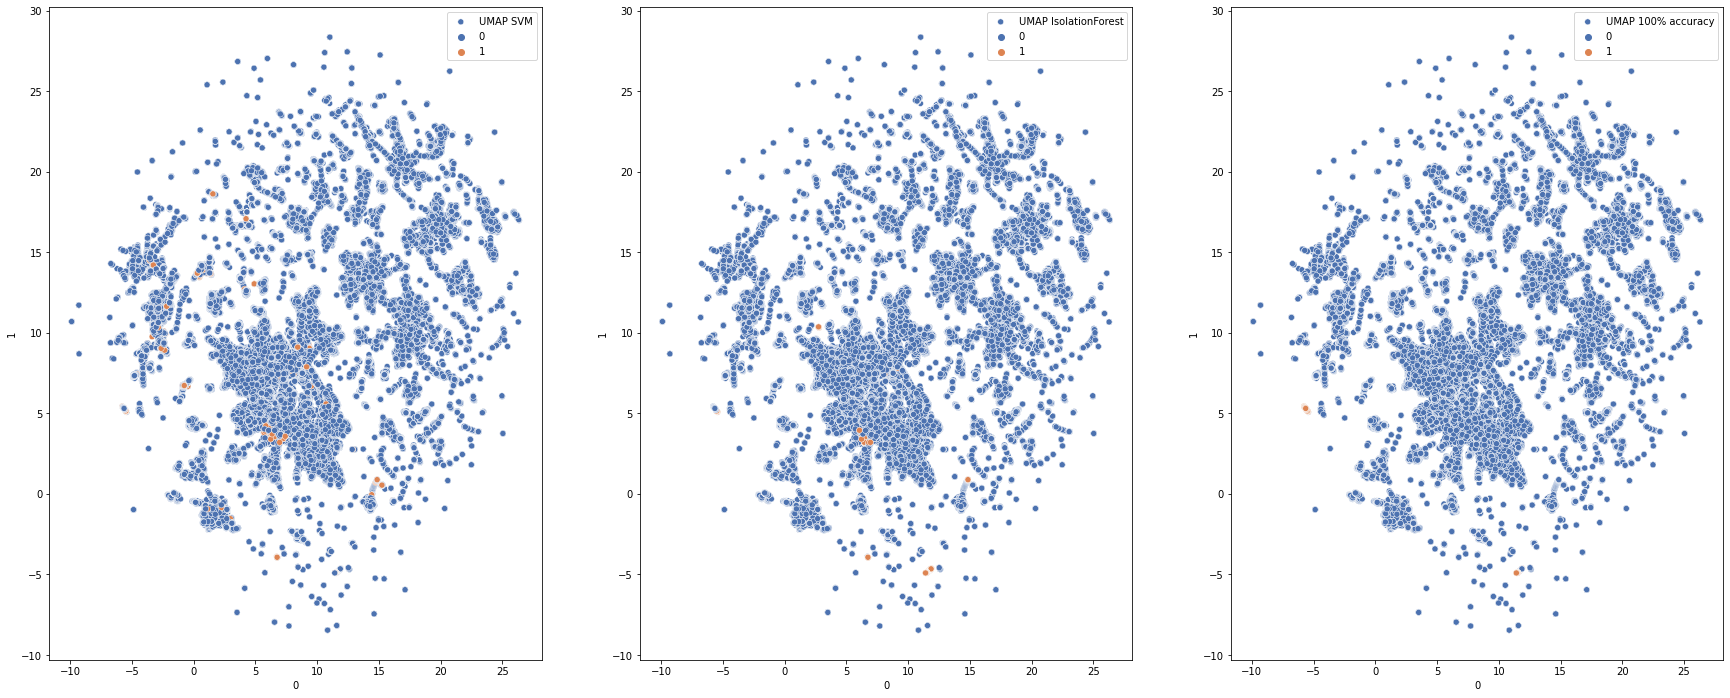

In [58]:
f, axs = plt.subplots(1,3,figsize=(30,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_UMAP['0'], y=X_UMAP['1'], hue=svm_outliers,palette= 'deep',legend='full',label = 'UMAP SVM').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_UMAP['0'], y=X_UMAP['1'], hue=isolation_outliers,palette= 'deep',legend='full',label = 'UMAP IsolationForest').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_UMAP['0'], y=X_UMAP['1'], hue=data.Class.values,palette= 'deep',legend='full',label = 'UMAP 100% accuracy').legend()

Визуализируем наши модели с помощью t-SNE и UMAP (10% выборки DBSCAN, и 100% accutacy)

In [59]:
#sne_10 = TSNE(perplexity=50, n_jobs=-1, random_state=2021)
#tsne_transformed_10 = tsne_10.fit_transform(X_test)
#pd.DataFrame(tsne_transformed_10).to_csv('/content/drive/MyDrive/STUDY/otus/HW/5/tsne_10.csv', index = False)
tsne_transformed_10 = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/5/tsne_10.csv')

In [61]:
#reducer_10 = umap.UMAP(random_state=2021)
#X_UMAP_10 = reducer_10.fit_transform(X_test)
#pd.DataFrame(X_UMAP_10).to_csv('/content/drive/MyDrive/STUDY/otus/HW/5/UMAP_10.csv', index = False)
X_UMAP_10 = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/5/UMAP_10.csv')

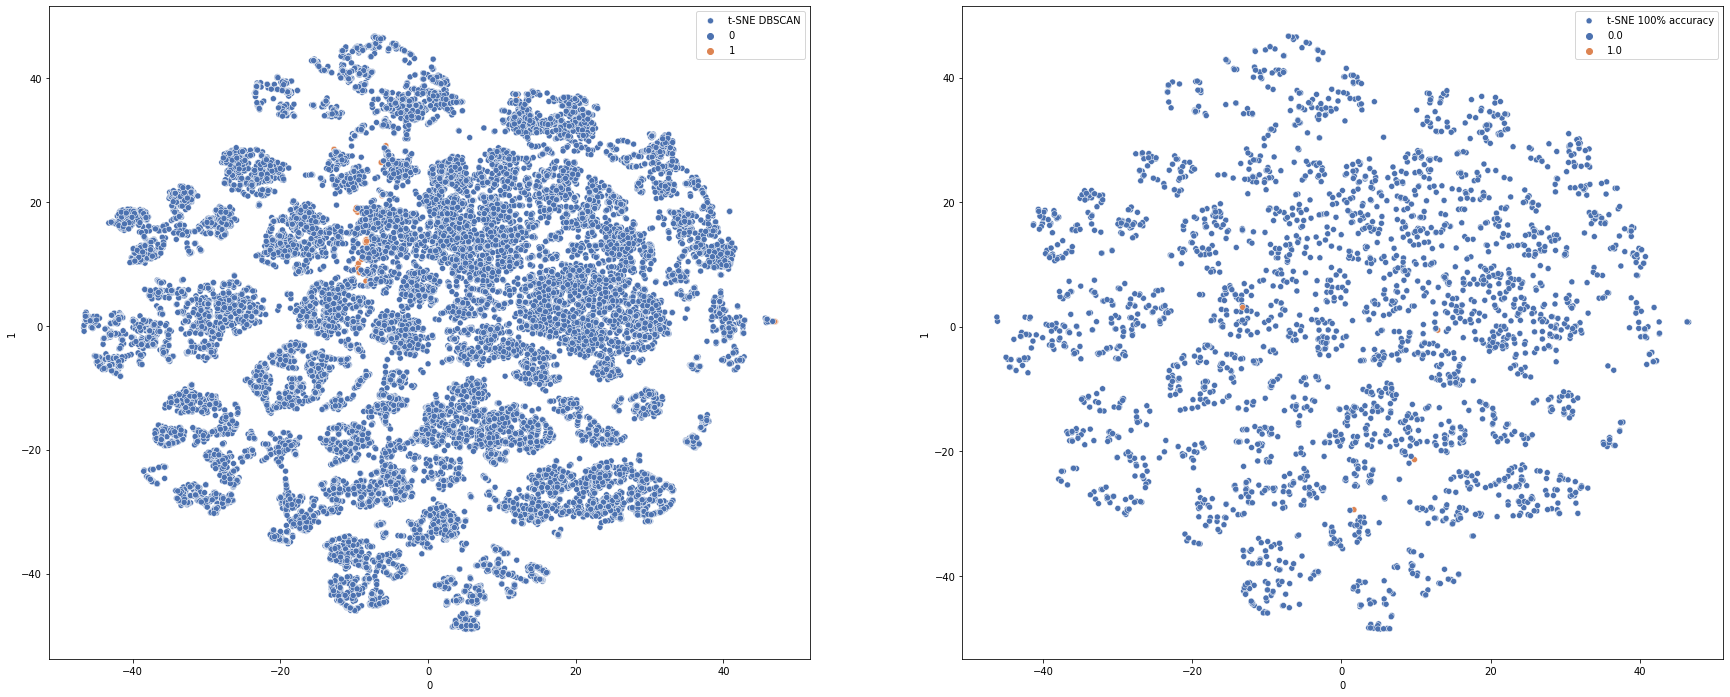

In [65]:
f, axs = plt.subplots(1,2,figsize=(30,12))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_transformed_10['0'], y=tsne_transformed_10['1'], hue=density_outlier, palette= 'deep',legend='full',label = 't-SNE DBSCAN').legend()
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_transformed_10['0'], y=tsne_transformed_10['1'], hue=y_test ,palette= 'deep',legend='full',label = 't-SNE 100% accuracy').legend()

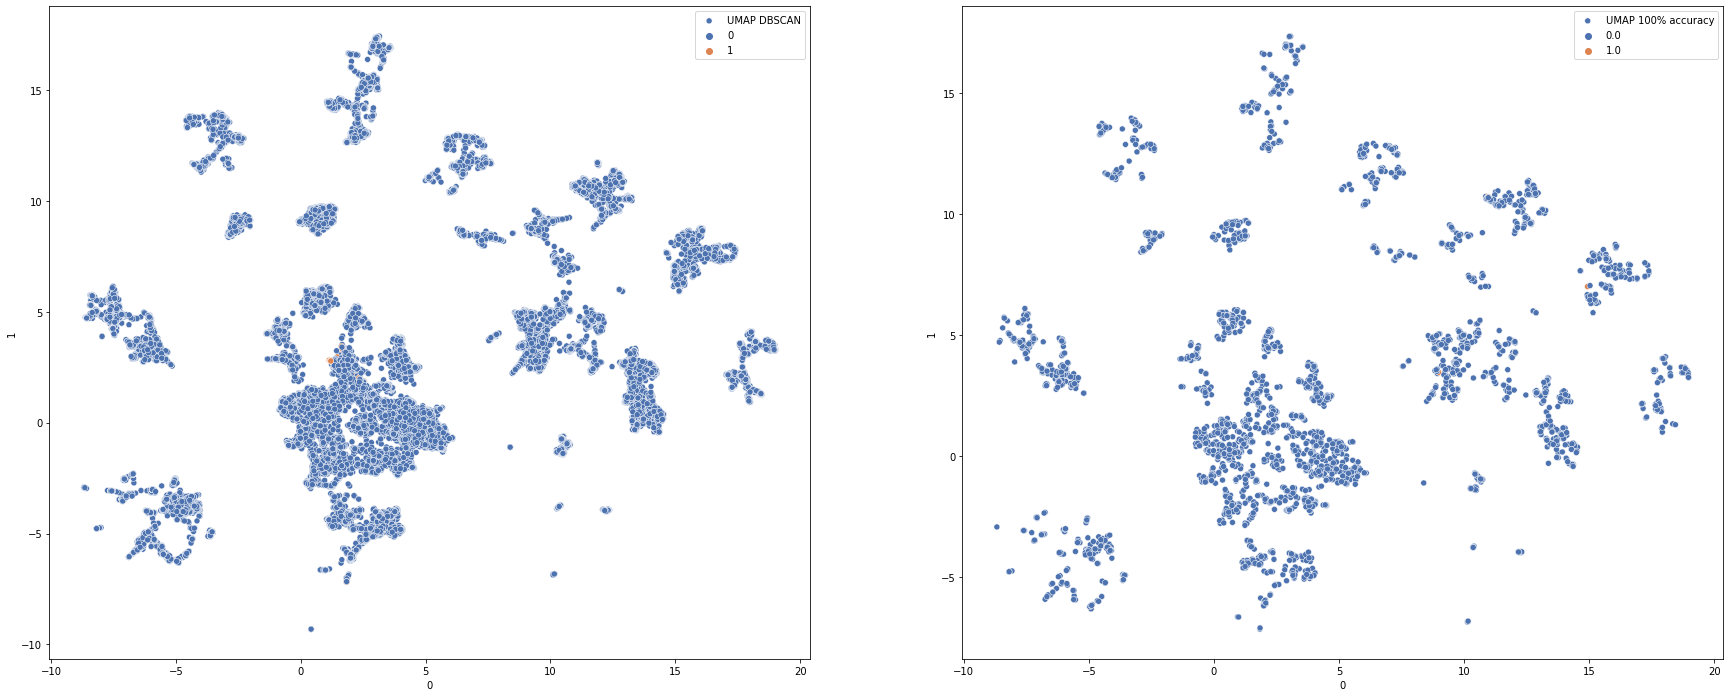

In [66]:
f, axs = plt.subplots(1,2,figsize=(30,12))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_UMAP_10['0'], y=X_UMAP_10['1'], hue=density_outlier, palette= 'deep',legend='full',label = 'UMAP DBSCAN').legend()
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_UMAP_10['0'], y=X_UMAP_10['1'], hue=y_test ,palette= 'deep',legend='full',label = 'UMAP 100% accuracy').legend()

Финальное сравниение

In [64]:
measured_metrics

error_type  Euclid_notime  Euclid_time  ...    DBSCAN       SVM  Isol_Forest
0   Accuracy       0.997339     0.997339  ...  0.997156  0.994315     0.997732
1  Precision       0.229675     0.229675  ...  0.142857  0.203252     0.343496
2     recall       0.229675     0.229675  ...  0.152174  0.075358     0.343496
3   F1-score       0.229675     0.229675  ...  0.147368  0.109951     0.343496

[4 rows x 7 columns]

# ИТОГИ

Резюмируя результаты можно сказать, что лучше всех аномалии в данном датасете ищет модель Isolation Forest. Втророе место - CityBlock (по F1 score).
Отобразили данные на 2-мерные плоскости с помощью t-SNE и UMAP.
По визуализации также видно, что есть совпадения с экспертными оценками.